<a href="https://colab.research.google.com/github/geetanshgoel2-coder/Assesment3/blob/main/Assessment_3_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PART 5: Conditional GAN - Fashion MNIST Image Generation

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import tensorflow as tf
from tensorflow.keras import layers


In [91]:
# Clone the Fashion-MNIST GitHub repository
!git clone https://github.com/zalandoresearch/fashion-mnist.git > /dev/null 2>&1
path = "fashion-mnist/data/fashion"

def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(-1, 28, 28, 1)
        data = (data.astype("float32") - 127.5) / 127.5
        return data

def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

x_train = load_images(f"{path}/train-images-idx3-ubyte.gz")
y_train = load_labels(f"{path}/train-labels-idx1-ubyte.gz")
print("Data loaded:", x_train.shape)

class_names = ['T-shirt/Top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle Boot']


Data loaded: (60000, 28, 28, 1)


In [92]:
#Build Generator
def build_generator(latent_dim=100, num_classes=10):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,), dtype='int32')

    label_embed = layers.Embedding(num_classes, latent_dim)(label)
    label_embed = layers.Flatten()(label_embed)
    input = layers.multiply([noise, label_embed])

    x = layers.Dense(7*7*128, use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7,7,128))(x)

    x = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    out = layers.Conv2DTranspose(1, (5,5), strides=(1,1), padding='same', activation='tanh')(x)
    return tf.keras.Model([noise, label], out)

latent_dim = 100
generator = build_generator(latent_dim)


In [93]:
# Build Discriminator

def build_discriminator(num_classes=10):
    image = layers.Input(shape=(28,28,1))
    label = layers.Input(shape=(1,), dtype='int32')
    label_embed = layers.Embedding(num_classes, 28*28)(label)
    label_embed = layers.Flatten()(label_embed)
    label_embed = layers.Reshape((28,28,1))(label_embed)

    x = layers.Concatenate()([image, label_embed])
    x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model([image, label], out)

discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002,0.5),
                      loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
# GAN

discriminator.trainable = False
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
fake_img = generator([noise, label])
validity = discriminator([fake_img, label])
gan = tf.keras.Model([noise, label], validity)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002,0.5),
            loss='binary_crossentropy')


In [5]:
# Train GAN

epochs = 2000
batch_size = 64
half_batch = batch_size // 2

for epoch in range(1, epochs + 1):
    # ---- Train Discriminator ----
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_imgs, real_labels = x_train[idx], y_train[idx]
    noise = np.random.normal(0,1,(half_batch, latent_dim))
    fake_labels = np.random.randint(0,10,half_batch)
    fake_imgs = generator([noise, fake_labels], training=False)

    real_y = np.ones((half_batch,1))
    fake_y = np.zeros((half_batch,1))
    d_loss_real = discriminator.train_on_batch([real_imgs, real_labels], real_y)
    d_loss_fake = discriminator.train_on_batch([fake_imgs, fake_labels], fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---- Train Generator ----
    noise = np.random.normal(0,1,(batch_size, latent_dim))
    gen_labels = np.random.randint(0,10,batch_size)
    valid_y = np.ones((batch_size,1))
    g_loss = gan.train_on_batch([noise, gen_labels], valid_y)

    # Print progress every 200 epochs
    if epoch % 200 == 0:
        print(f"Epoch {epoch}/{epochs} | D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.1f}% | G loss: {g_loss:.4f}")

        # Show preview every 500 epochs
        if epoch % 500 == 0:
            noise = np.random.normal(0, 1, (10, latent_dim))
            labels = np.arange(0,10).reshape(-1,1)
            gen_imgs = generator([noise, labels], training=False)
            gen_imgs = 0.5 * gen_imgs.numpy() + 0.5
            plt.figure(figsize=(10,2))
            for i in range(10):
                plt.subplot(1,10,i+1)
                plt.imshow(gen_imgs[i,:,:,0], cmap='gray')
                plt.axis('off')
            plt.show()

NameError: name 'x_train' is not defined

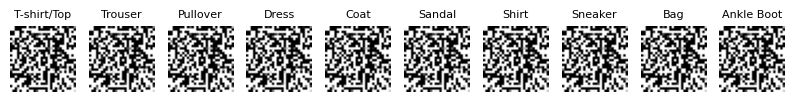

In [96]:
# Samples

# Create random noise and one label for each clothing type (0–9)
noise = np.random.normal(0, 1, (10, latent_dim))
labels = np.arange(0, 10).reshape(-1, 1)

# Use the trained generator to make new images
gen_imgs = generator([noise, labels], training=False)
gen_imgs = 0.5 * gen_imgs.numpy() + 0.5  # scale to [0,1]

# Class names for reference
class_names = ['T-shirt/Top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle Boot']

# Plot each generated image
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
    plt.title(class_names[i], fontsize=8)
    plt.axis('off')
plt.show()